In [1]:
import pyro
import torch
import matplotlib.pyplot as plt
import zuko

from scripts.seismic.model import NX_COARSE, NY_COARSE, seismic_model
from scripts.seismic.train import plot_logprob_calibration, plot_posterior_interp, elbo_loss
from scripts.utils import kl_divergence

def load_flow(flow_path, device):
    """Load a trained flow."""
    flow = zuko.flows.NSF(features=NX_COARSE * NY_COARSE, context=1).to(device)
    flow.load_state_dict(torch.load(flow_path))
    flow.eval()
    return flow

seed = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(seed)
pyro.set_rng_seed(seed)

# Load a trained flow and plot the log probability calibration
name = "swi_vi_amortized_calibrated_regularized_kl_beta_1.00"
flow_path = "../../checkpoints/swi/" + name + "/checkpoint_299.pth"
guide = load_flow(flow_path, device=device)


In [4]:
# Make a bunch of eval data
n_failure = 2
n_nominal = 50
with torch.no_grad():
        profile_background = torch.zeros(NY_COARSE, NX_COARSE, device=device)

        # Nominal has a layer of higher vp, vs, and rho in the middle
        profile_nominal = profile_background.expand(n_nominal, -1, -1).clone()
        profile_nominal[:, 3:6, 1:9] = 1.0
        profile_nominal += 0.25 * torch.randn_like(profile_nominal)

        # Failure has a break in the middle of the layer
        profile_failure = profile_background.expand(n_failure, -1, -1).clone()
        profile_failure[:, 3:6, 0:4] = 1.0
        profile_failure[:, 4:7, 6:10] = 1.0
        profile_failure += 0.25 * torch.randn_like(profile_failure)

        # Generate the data for the nominal and failure cases
        observation_noise_scale = 1e-2

        nominal_observations = []
        for i in range(n_nominal):
            nominal_model = pyro.poutine.condition(
                seismic_model, data={"profile": profile_nominal[i]}
            )
            nominal_observations.append(
                nominal_model(
                    N=1,
                    observation_noise_scale=observation_noise_scale,
                    device=device,
                )
            )
        nominal_observations = torch.cat(nominal_observations)

        failure_observations = []
        for i in range(n_failure):
            failure_model = pyro.poutine.condition(
                seismic_model, data={"profile": profile_failure[i]}
            )
            failure_observations.append(
                failure_model(
                    N=1, observation_noise_scale=observation_noise_scale, device=device
                )
            )
        failure_observations = torch.cat(failure_observations)

num_elbo_particles = 10
num_divergence_particles = 10
num_divergence_points = 10
nominal_label = torch.tensor([0.0], device=device)
divergence_bounds = torch.linspace(0.0, 1.0, num_divergence_points).to(device)
nominal_context = torch.tensor([[0.0]] * num_divergence_points).to(device)

with torch.no_grad():
    divergences = kl_divergence(
        guide,
        guide,
        divergence_bounds.reshape(-1, 1),
        nominal_context,
        num_divergence_particles,
    )
    failure_divergence = divergences[-1]

elbos = []
elbo_grads = []
for x in divergence_bounds:
    # What is the derivative of the ELBO wrt the divergence bound?
    x.requires_grad_(True)
    result = elbo_loss(
        seismic_model,
        guide,
        x.reshape(1),
        num_elbo_particles,
        N=n_failure,
        receiver_observations=failure_observations,
    )
    elbo = result[0]
    elbo.backward()
    elbos.append(elbo.detach().cpu().item())
    elbo_grads.append(x.grad.detach().cpu().item())

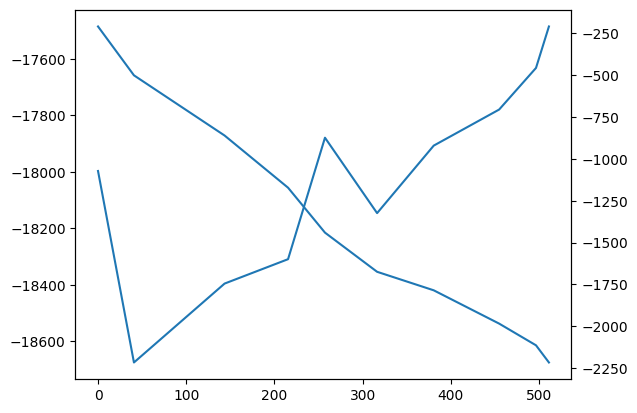

In [5]:
plt.plot(divergences.cpu(), elbos)
ax = plt.gca().twinx()
ax.plot(divergences.cpu(), elbo_grads)